In [5]:
# Re-calculating to be sure
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Reload
df_gdp = pd.read_csv('cleaned_data/gdp_data_cleaned.csv')
df_cpi = pd.read_csv('cleaned_data/cpi_data_cleaned.csv')
df_pat = pd.read_csv('cleaned_data/pat_data_cleaned.csv')

# Ensure numeric and clean
years = [str(y) for y in range(2015, 2025)]
for y in years:
    df_gdp[y] = pd.to_numeric(df_gdp[y], errors='coerce')

# 1. GDP YoY Growth
df_gdp_growth = df_gdp[['Category']].copy()
growth_years = [str(y) for y in range(2016, 2025)]
for y_curr, y_prev in zip(growth_years, years[:-1]):
    df_gdp_growth[y_curr] = ((df_gdp[y_curr] - df_gdp[y_prev]) / df_gdp[y_prev]) * 100

# 2. Avg Growth and Contribution
df_gdp_growth['Avg_Growth'] = df_gdp_growth[growth_years].mean(axis=1)
contrib_df = df_gdp[['Category']].copy()
for y in years:
    contrib_df[y] = (df_gdp[y] / df_gdp[y].sum()) * 100
df_gdp_growth['Avg_Contribution'] = contrib_df[years].mean(axis=1)

# 3. CPI Calculations
# Filter for Index and pivot
df_indices = df_cpi[df_cpi['Metric_Type'] == 'Index'].copy()
df_cpi_pivot = df_indices.pivot(index='Component', columns='Year', values='Value')
df_cpi_inflation = df_cpi_pivot.pct_change(axis=1) * 100
df_cpi_pivot['Cumulative_Increase_%'] = ((df_cpi_pivot[2024] - df_cpi_pivot[2015]) / df_cpi_pivot[2015]) * 100

# 4. Company Performance Alignment
company_mapping = {
    'Conoil': 'Manufacturing - Oil & Gas',
    'Dangote Cement': 'Manufacturing',
    'MTN': 'Information and Communication',
    'Nestle Niger': 'Manufacturing',
    'Okomu Oil': 'Agriculture - Agriculture',
    'Seplat Energy': 'Manufacturing - Oil & Gas',
    'Zenith Bank': 'Financial and Insurance'
}

company_results = []
for company, sector in company_mapping.items():
    comp_pat = df_pat[df_pat['Company'] == company].copy()
    sect_gdp_growth = df_gdp_growth[df_gdp_growth['Category'] == sector][growth_years].melt(var_name='Year', value_name='Sector_Growth')
    sect_gdp_growth['Year'] = sect_gdp_growth['Year'].astype(int)
    
    # Merge on year
    merged = pd.merge(comp_pat, sect_gdp_growth, on='Year')
    merged['Sector'] = sector
    company_results.append(merged)

df_comp_perf = pd.concat(company_results)


C:\Users\PC\AppData\Local\Temp\ipykernel_23432\1420915244.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_growth, x='2024', y='Category', ax=axes[0], palette='viridis')
C:\Users\PC\AppData\Local\Temp\ipykernel_23432\1420915244.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_contrib, x='Avg_Contribution', y='Category', ax=axes[1], palette='magma')
C:\Users\PC\AppData\Local\Temp\ipykernel_23432\1420915244.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_least, x='Avg_Growth', y='Category', palette='c

Calculations and Plots saved.


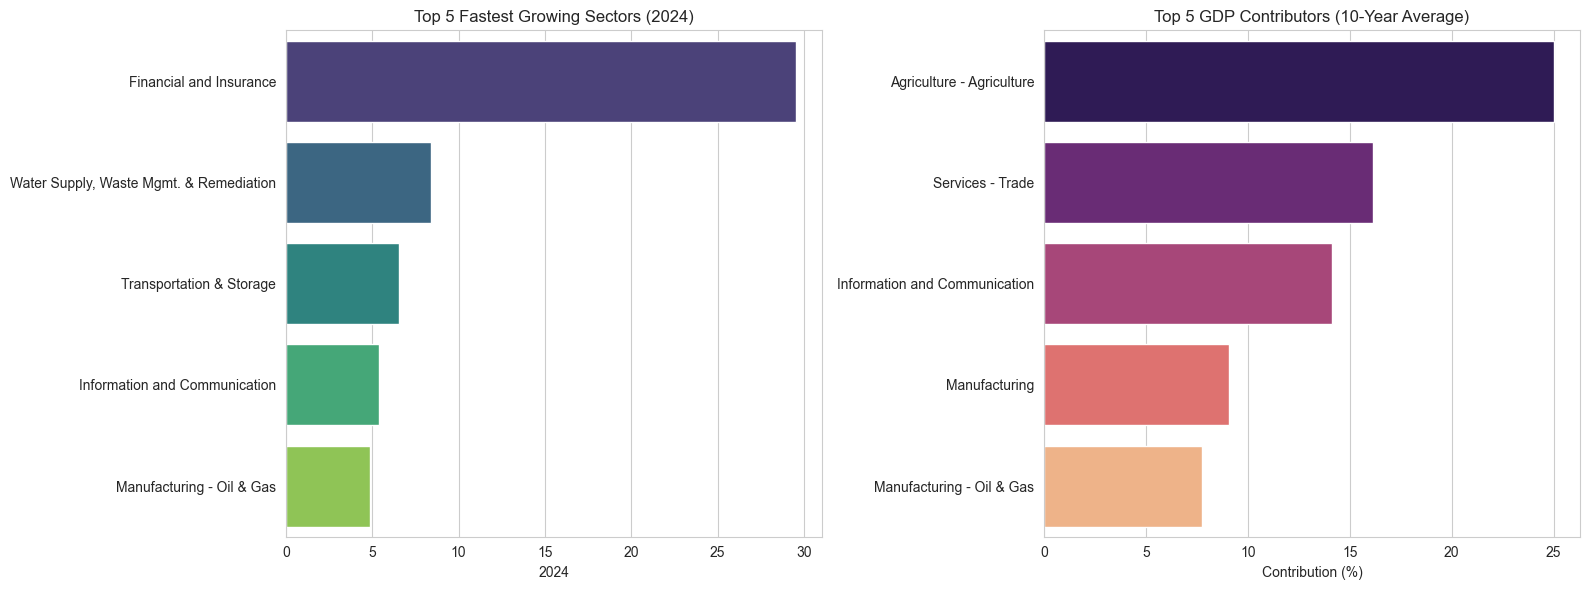

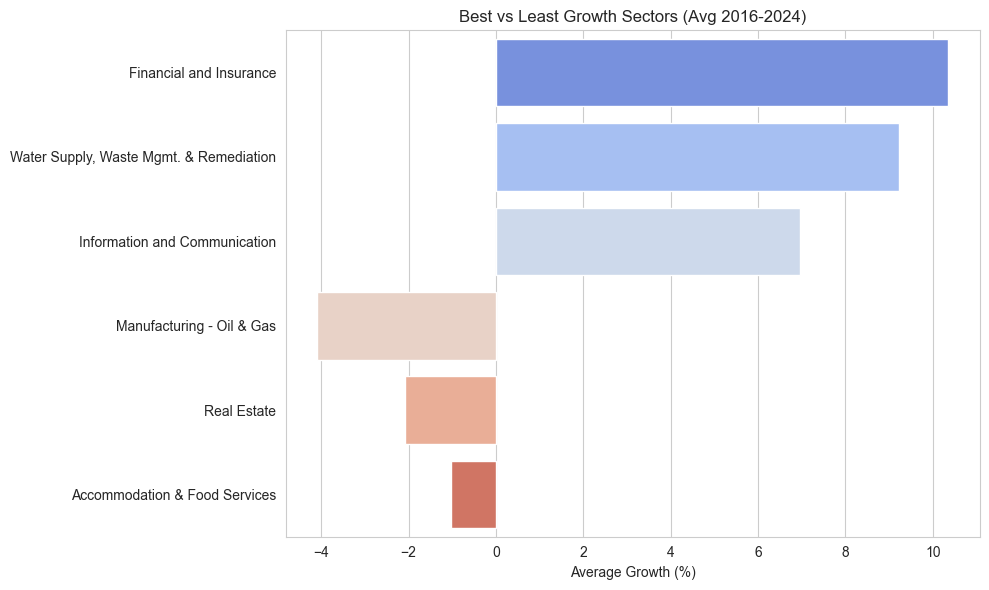

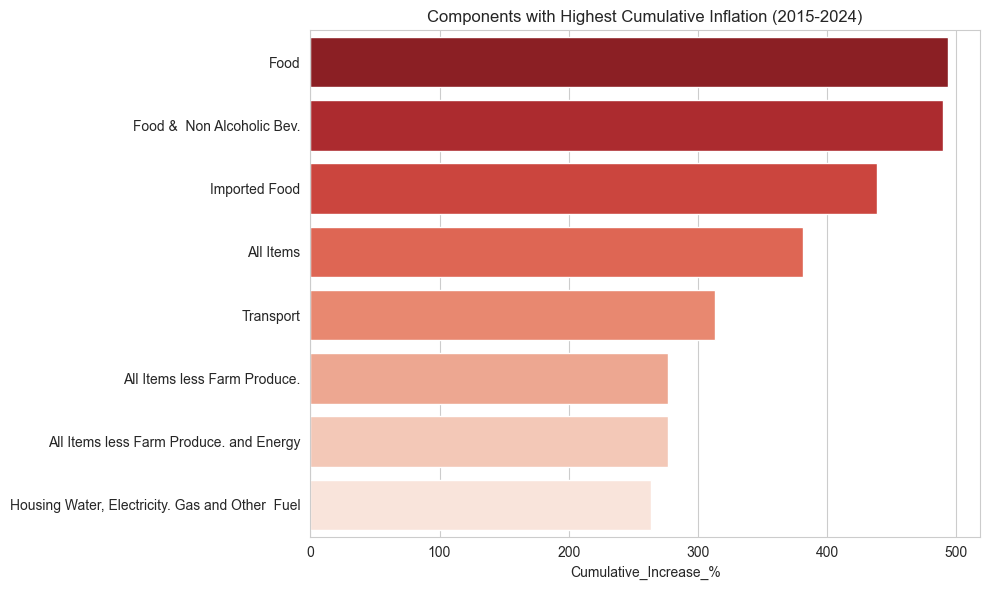

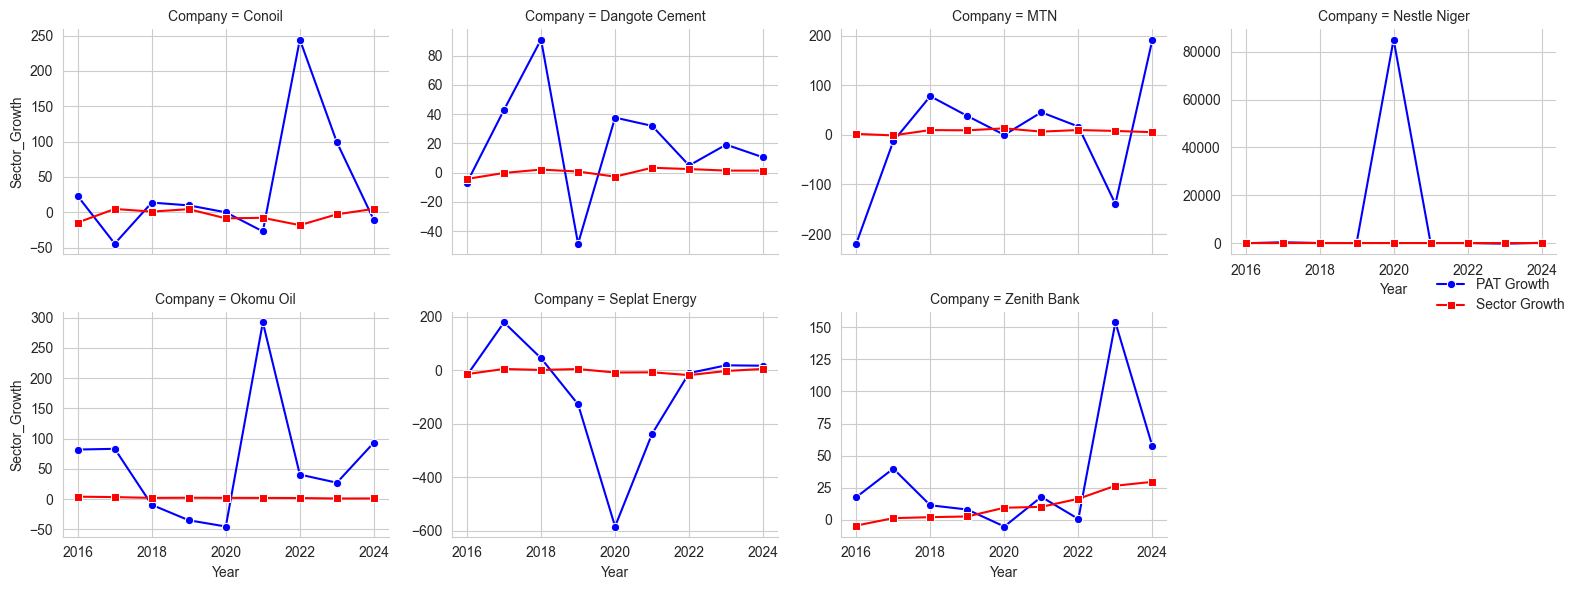

In [15]:

# --- PLOTTING ---
os.makedirs('figures', exist_ok=True)
os.makedirs('intermediate_datasets', exist_ok=True)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Plot 1: Top Growth & Contrib 2024
top5_growth = df_gdp_growth.sort_values('2024', ascending=False).head(5)
top5_contrib = df_gdp_growth.sort_values('Avg_Contribution', ascending=False).head(5)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=top5_growth, x='2024', y='Category', ax=axes[0], palette='viridis')
axes[0].set_title('Top 5 Fastest Growing Sectors (2024)')
axes[0].set_ylabel('')


sns.barplot(data=top5_contrib, x='Avg_Contribution', y='Category', ax=axes[1], palette='magma')
axes[1].set_title('Top 5 GDP Contributors (10-Year Average)')
axes[1].set_ylabel('')
axes[1].set_xlabel('Contribution (%)')
plt.tight_layout()
plt.savefig('figures/gdp_rankings.png')

# Plot 2: Best/Least Growth 10 Years
best_least = pd.concat([df_gdp_growth.nlargest(3, 'Avg_Growth'), df_gdp_growth.nsmallest(3, 'Avg_Growth')])
plt.figure(figsize=(10, 6))
sns.barplot(data=best_least, x='Avg_Growth', y='Category', palette='coolwarm')
plt.title('Best vs Least Growth Sectors (Avg 2016-2024)')
plt.ylabel('')
plt.xlabel('Average Growth (%)')
plt.tight_layout()
plt.savefig('figures/gdp_growth_extremes.png')

# Plot 3: Inflation Impact
highest_inf = df_cpi_pivot['Cumulative_Increase_%'].sort_values(ascending=False).head(8).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=highest_inf, x='Cumulative_Increase_%', y='Component', palette='Reds_r')
plt.title('Components with Highest Cumulative Inflation (2015-2024)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/cpi_cumulative_impact.png')

# Plot 4: Company vs Sector (Grid)
# Filtering for a subset to avoid overcrowding or use a specific plotting logic
g = sns.FacetGrid(df_comp_perf, col="Company", col_wrap=4, height=3, aspect=1.2, sharey=False)
g.map(sns.lineplot, "Year", "PAT_Growth_%", marker="o", color="blue", label="PAT Growth")
g.map(sns.lineplot, "Year", "Sector_Growth", marker="s", color="red", label="Sector Growth")
g.add_legend()
plt.tight_layout()
plt.savefig('figures/company_sector_trends.png')

# Export clean version of calculations for user
df_gdp_growth.to_csv('intermediate_datasets/gdp_growth_calculated.csv', index=False)
df_comp_perf.to_csv('intermediate_datasets/company_sector_comparison.csv', index=False)
df_cpi_inflation.to_csv('intermediate_datasets/cpi_inflation_calculated.csv')

print("Calculations and Plots saved.")